<a href="https://colab.research.google.com/github/antoh/DataScience/blob/main/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Changing from regression to classification:

- change last activation to Sigmoid to get a value between 0 and 1
- use as many output nodes as you have choices (2 choices = 2 nodes)
- use CrossEntropyLoss to better measure error for classification

We are using "logistic regression" for classification tasks because the logistic function (aka, sigmoid) looks like a sideways "S" and ranges between 0 and 1. It essentially produces a "percent likelihood" that the data is in class A or B, etc.

In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import random
import sklearn.metrics

In [3]:
adultdf = pd.read_csv("/content/drive/MyDrive/DataScience/LogisticRegression/adult.data", header=None)
adultdf.columns = ["age", "workclass", "fnlwgt", "education", "educationNum",
                  "maritalStatus", "occupation", "relationship", "race",
                  "sex", "capitalGain", "capitalLoss", "hoursPerWeek",
                  "nativeCountry", "income"]
adultdf

,age,workclass,fnlwgt,education,educationNum,maritalStatus,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursPerWeek,nativeCountry,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


Need to turn some of these categorical columns into "one-hot" columns, such as workclass: Private = {0,0,0}, Self-emp-not-inc = {0,1,0}, etc. This way, the neural net does not see labels like Private = 1, Self-emp-not-inc = 2, etc. which may lead it to believe Private is "close to" Self-emp-not-inc, etc.

In [4]:
# example of pandas' get_dummies on a single column:
pd.get_dummies(adultdf[["workclass"]], prefix=["workclass"], columns=["workclass"])

,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay
0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
32556,0,0,0,0,1,0,0,0,0
32557,0,0,0,0,1,0,0,0,0
32558,0,0,0,0,1,0,0,0,0
32559,0,0,0,0,1,0,0,0,0


In [5]:
onehot_columns = ["relationship"]
x = pd.get_dummies(adultdf[onehot_columns],
                    prefix=onehot_columns,
                    columns=onehot_columns)
x

,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife
0,0,1,0,0,0,0
1,1,0,0,0,0,0
2,0,1,0,0,0,0
3,1,0,0,0,0,0
4,0,0,0,0,0,1
...,...,...,...,...,...,...
32556,0,0,0,0,0,1
32557,1,0,0,0,0,0
32558,0,0,0,0,1,0
32559,0,0,0,1,0,0


Because we are doing classification, we will use CrossEntropyLoss for our criterion function. The documentation shows that the "input" (the last layer of the network) should have 2 neurons because we have two classes (<=50K, >50K) for our target. The docs also show we need to make our y target values a single number that is 0 or 1 (since we have two classes). We do not use "onehot" encoding on these y values.

*   If <= 50 set to 0
*   If >50 set to 1




In [6]:
y = pd.Series([x == ' <=50K' for x in list(adultdf["income"])])
y

0         True
1         True
2         True
3         True
4         True
         ...  
32556     True
32557    False
32558     True
32559     True
32560    False
Length: 32561, dtype: bool

**NOTE!!!**

There are only 24% of one class, so our model has to at least get less error than this! It can simply learn to always say "1" or whatever, ignoring the input data, and still be wrong only 24% of the time!

In [7]:
y_true = len(list(filter(lambda x: x, y)))
y_false = len(list(filter(lambda x: not x, y)))
print(y_true, y_false, 1-float(y_true)/float(y_true+y_false))

24720 7841 0.2408095574460244


In [8]:
indexes = pd.Series(y.sample(frac=1.0, random_state=0).index)
train_idxs = indexes.iloc[range(0, int(len(indexes)*0.6))]
val_idxs = indexes.iloc[range(int(len(indexes)*0.6), int(len(indexes)*0.8))]
test_idxs = indexes.iloc[range(int(len(indexes)*0.8), len(indexes))]
train_x = x.iloc[train_idxs]
val_x = x.iloc[val_idxs]
test_x = x.iloc[test_idxs]
train_y = y.iloc[train_idxs]
val_y = y.iloc[val_idxs]
test_y = y.iloc[test_idxs]
train_y

22278     True
8950      True
7838      True
16505     True
19140    False
         ...  
14525     True
26826    False
18552     True
17957    False
27290    False
Length: 19536, dtype: bool

In [9]:
train_y = train_y.astype(int)
val_y = val_y.astype(int)
test_y = test_y.astype(int)


In [109]:
val_y

9785     0
6767     1
23690    1
23426    1
18763    0
        ..
3690     1
12877    1
13288    1
2751     1
11903    1
Length: 6512, dtype: int64

In [10]:
model = torch.nn.Sequential(
    torch.nn.Linear(train_x.shape[1], 100), # compute number of columns from shape
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5), # 50% of weights will not be trained each epoch
    torch.nn.Linear(100, 2),
    torch.nn.Sigmoid()
)
model.cuda()

RuntimeError: ignored

In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [110]:
train_x_gpu = torch.tensor(train_x.to_numpy()).float().cuda()
val_x_gpu = torch.tensor(val_x.to_numpy()).float().cuda()
train_y_gpu = torch.tensor(train_y.to_numpy()).long().cuda()
val_y_gpu = torch.tensor(val_y.to_numpy()).long().cuda()
train_y_gpu

tensor([1, 1, 1,  ..., 1, 0, 0], device='cuda:0')

In [1]:
losses_train = []
losses_val = []

accur_train = []
accur_val = []

for epoch in range(100):

    optimizer.zero_grad()
    train_pred = model(train_x_gpu)
    train_loss = criterion(train_pred, train_y_gpu)
    val_pred = model(val_x_gpu)
    val_loss = criterion(val_pred, val_y_gpu)
   
    # compute % accuracy (actually, error)
    # if epoch == 1 or epoch % 5 == 0:
    #   print("Loss at iteration {}: {}".format(epoch, train_loss))
    # # first, convert the two outputs into a single prediction
    train_pred_label = [0 if pred[0] > pred[1] else 1 for pred in train_pred.cpu().detach().tolist()]
    val_pred_label = [0 if pred[0] > pred[1] else 1 for pred in val_pred.cpu().detach().tolist()]
    train_accur = sklearn.metrics.accuracy_score(train_y_gpu.cpu().tolist(), train_pred_label)
    val_accur = sklearn.metrics.accuracy_score(val_y_gpu.cpu().tolist(), val_pred_label)
    # print(train_loss.item(), val_loss.item(), train_error, val_error)

    train_loss.backward()
    val_loss.backward
    optimizer.step()
    
    #train Loss
    if (epoch+1)% 2 == 0:
      losses_train.append(train_loss)
      accur_train.append(train_accur)
      #print("Train epoch {}\tloss : {}".format(epoch,loss))
      print("Validation epoch {}\tloss : {}\t Validation accuracy : {}".format(epoch,train_loss,train_accur))
     #print('epoch:', epoch+1,',loss=',loss.item())
    if (epoch+1)% 2 == 0:
      losses_val.append(val_loss)
      accur_val.append(val_accur)
      # accur.append(acc)
      #print("Validation epoch {}\tloss : {}".format(epoch,loss))
      print("Validation epoch {}\tloss : {}\t Validation accuracy : {}".format(i,val_loss,val_accur))


NameError: ignored

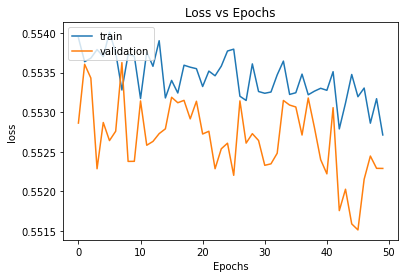

In [136]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['train','validation'], loc='upper left')
plt.show()

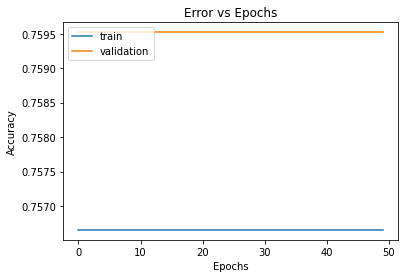

In [137]:
plt.plot(accur_train)
plt.plot(accur_val)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [ ]:
val_pred_label

In [127]:
test_x_gpu = torch.tensor(test_x.to_numpy()).float().cuda()
test_y_gpu = torch.tensor(test_y.to_numpy()).long().cuda()


In [158]:
for epoch in range(100):
    optimizer.zero_grad()
    test_pred = model(test_x_gpu)
    test_loss = criterion(test_pred, test_y_gpu)
       
   # first, convert the two outputs into a single prediction
    test_pred_label = [0 if pred[0] > pred[1] else 1 for pred in train_pred.cpu().detach().tolist()]
    test_error = 1.0 - sklearn.metrics.accuracy_score(train_y_gpu.cpu().tolist(), train_pred_label)

    test_loss.backward()
    optimizer.step()


In [148]:
len(test_pred)

6513

In [144]:
print(test_pred.argmax(dim=1))
print(test_y_gpu)

tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')
tensor([1, 1, 0,  ..., 1, 0, 1], device='cuda:0')


Stack the two tensors

In [159]:
stacked = torch.stack(
    (
        test_y_gpu
        ,test_pred.argmax(dim=1)
    )
    ,dim=1
)

stacked.shape

torch.Size([6513, 2])

In [160]:
##Stack is of 6513 and two columns
stacked[0].tolist()

[1, 1]

The problem has two classes thus we create 2 classes for the data

In [161]:
#Create Matrix 
cmt = torch.zeros(2,2, dtype=torch.int64) #Create 2 * 2 Matrix

#Iterate over iterate over the prediction-target pairs and add one to the value inside the matrix each time the particular position occurs.
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

cmt


tensor([[   0, 1521],
        [   0, 4992]])

We get confusion matrix as tensor object as above